# Fashion MNIST Image Classification
---

## Import Libraries

In [1]:
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, auc

## Prepare Data

- convert ubyte to a dataframe.

In [2]:
def read_ubyte(fp_img, fp_lbl, fp_out=None):
	l= []
	with gzip.open(fp_lbl, 'rb') as f:
		f.read(8)
		l= [[x] for x in f.read()]
	
	with gzip.open(fp_img, 'rb') as f:
		f.read(16)
		for i in range(len(l)):
			l[i].extend([c for c in f.read(28*28)])

	if fp_out is not None:#convert ubyte into csv
		with open(fp_out, 'w') as f:
			f.write(','.join(['label']+[f'{i}' for i in range(28*28)])+'\n')
			for row in l:
				f.write(','.join(str(col) for col in row)+'\n')
	
	return pd.DataFrame(l, columns=['label']+[i for i in range(28*28)])

## Load Data

Fashion MNIST dataset courtesy of: https://github.com/zalandoresearch/fashion-mnist

60,000 samples in the training dataset.

10,000 samples in the testing dataset.

Each sample is a 28x28 grayscale image (784 pixels/columns) associated with a label from 10 classes:
- 0. T-shirt/top
- 1. Trouser
- 2. Pullover
- 3. Dress
- 4. Coat
- 5. Sandal
- 6. Shirt
- 7. Sneaker
- 8. Bag
- 9. Ankle boot

For our purpose, we'll select the first classes.


In [3]:
df_trn= read_ubyte('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')

In [4]:
df_trn

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,66,54,50,5,0,1,0,0,0,0


In [167]:
print('duplicated rows: ', df_trn.duplicated().sum())
print('missing values:  ', df_trn.isna().sum().sum())

duplicated rows:  0
missing values:   0


In [6]:
df_tst= read_ubyte('t10k-images-idx3-ubyte.gz',  't10k-labels-idx1-ubyte.gz')

In [7]:
df_tst

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,2,3,0,3,174,189,67,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,164,58,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,6,0,0,0,2,0,1,1,0,0,...,71,12,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,27,0,0,0,0,0,0,0,0,0
9998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
print('duplicated rows: ', df_tst.duplicated().sum())
print('missing values:  ', df_tst.isna().sum().sum())

duplicated rows:  0
missing values:   0


In [170]:
df_trn['label'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [171]:
df_tst['label'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

select 5 classses

In [172]:
df_trn= df_trn[df_trn['label']<5]

In [173]:
df_tst= df_tst[df_tst['label']<5]

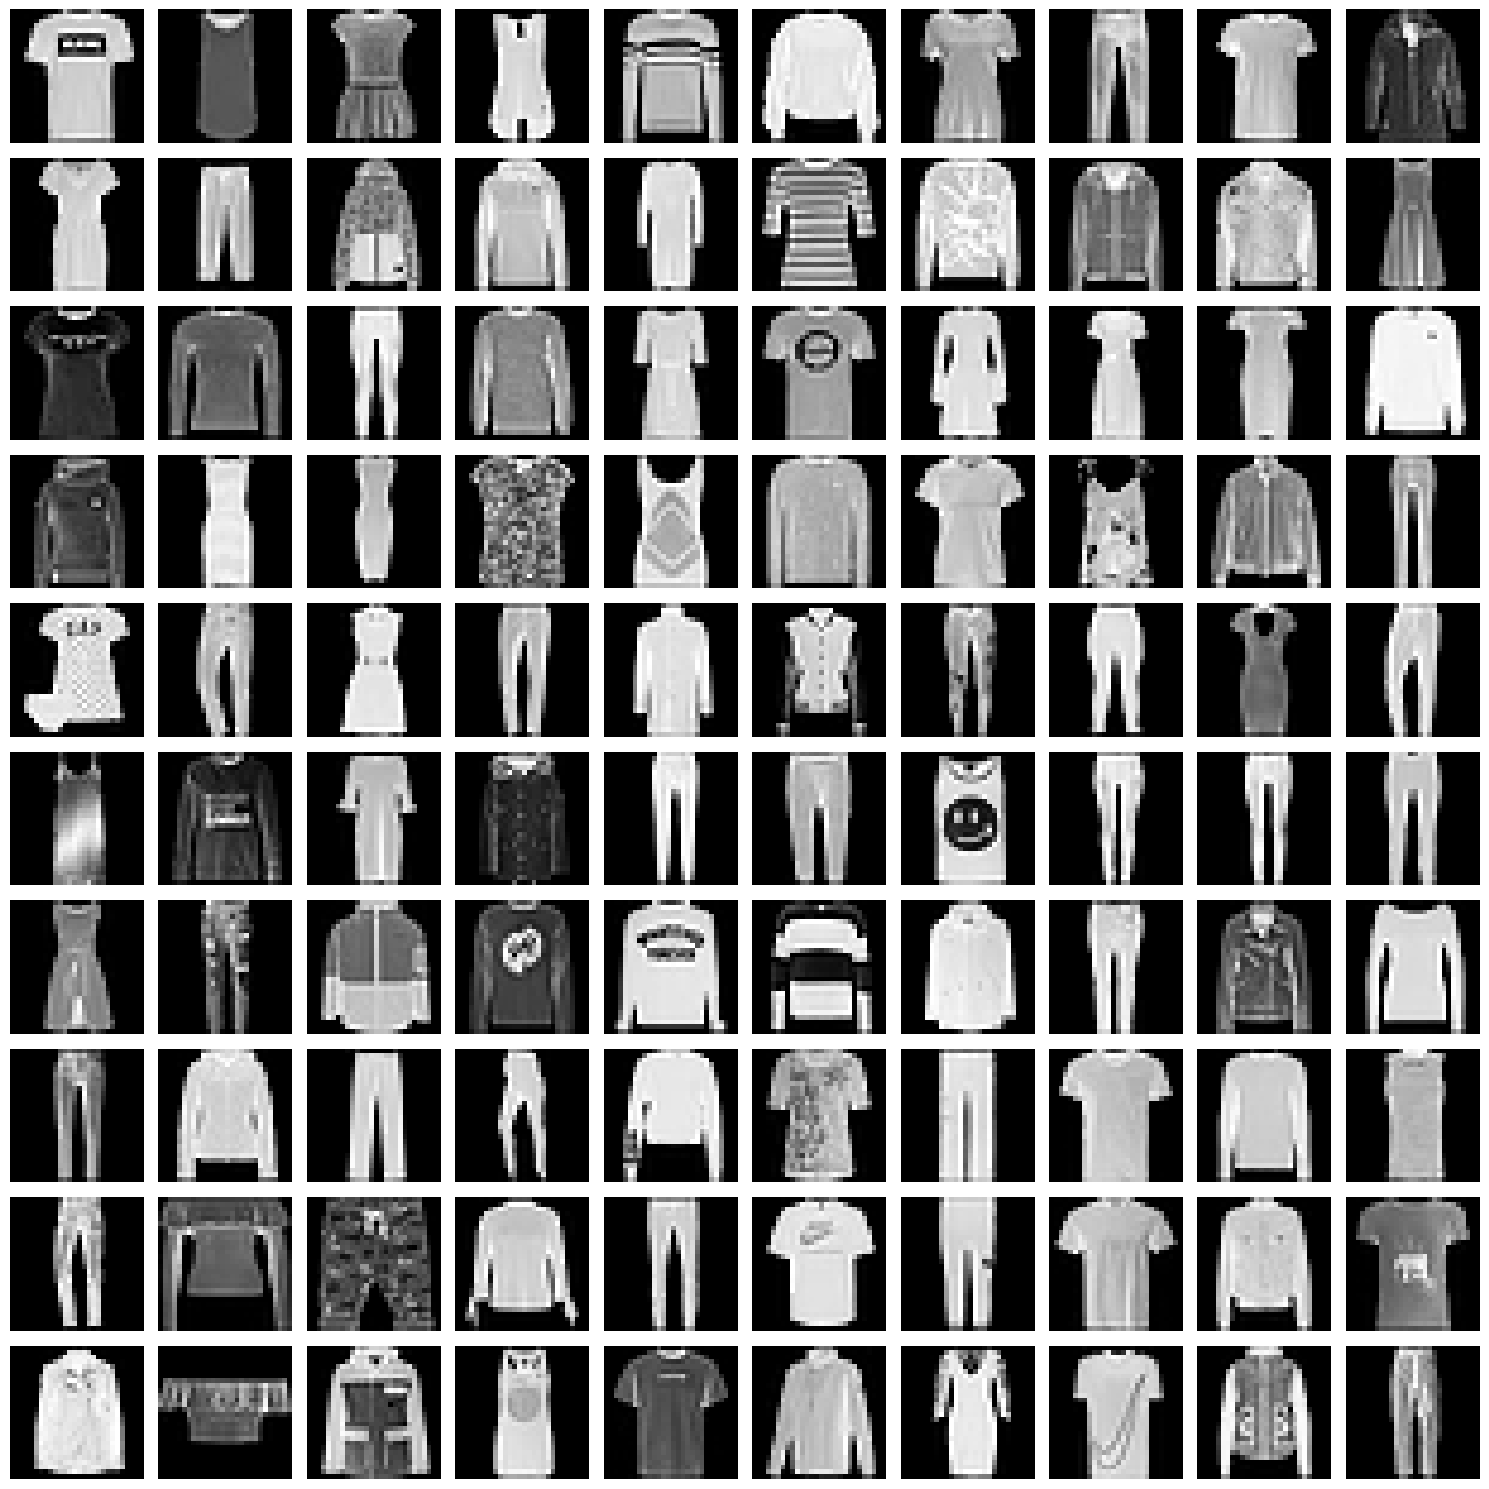

In [174]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
	ax.imshow(np.array(df_trn.iloc[i, 1:]).reshape(28, 28), cmap='gray')
	ax.axis('off')
plt.tight_layout()
plt.show()

## Data Preprocessing

### Feature Selection

In [175]:
X_trn= df_trn.drop('label', axis=1)
y_trn= df_trn['label']

X_tst= df_tst.drop('label', axis=1)
y_tst= df_tst['label']

### Scaling

In [176]:
scaler= StandardScaler()

In [177]:
X_trn= scaler.fit_transform(X_trn)
X_tst= scaler.transform(X_tst)

### PCA

In [178]:
from sklearn.decomposition import PCA

In [179]:
pca= PCA(0.90)#supply only 90% of the most useful data in the dataset

In [180]:
X_trn= pca.fit_transform(X_trn)
X_tst= pca.transform(X_tst)

In [204]:
print(f'PCA number of useful columns: {pca.n_components_}')

PCA number of useful columns: 114


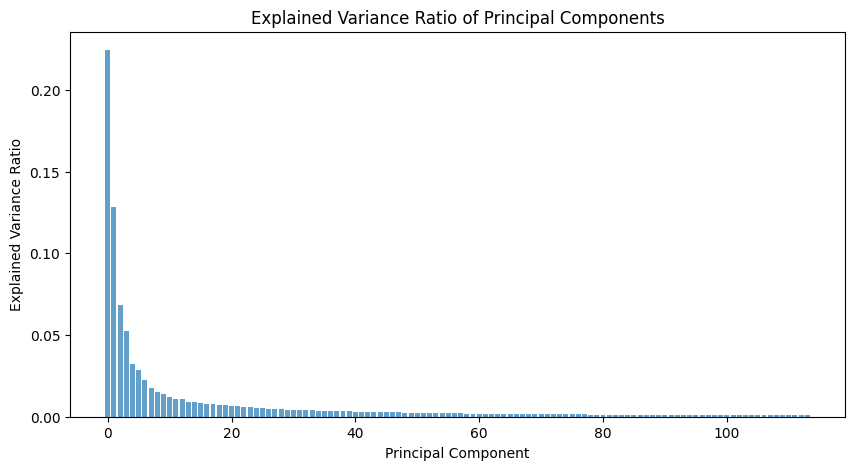

In [203]:
plt.figure(figsize=(10, 5))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

## Model Training

In [183]:
def model_evaluate(model):
	pred= model.predict(X_tst)
	print('Train Accuracy:  ', accuracy_score(y_trn, model.predict(X_trn)))
	print('Test Accuracy:   ', accuracy_score(y_tst, pred))
	print('Precision Score: ', precision_score(y_tst, pred, average='macro'))
	print('Recall Score:    ', recall_score(y_tst, pred, average='macro'))
	print('Classification Report\n', classification_report(y_tst, pred))
	ConfusionMatrixDisplay(confusion_matrix(y_tst, pred)).plot()
	plt.show()

In [184]:
def model_roc(model):
	fpr= {}
	tpr= {}
	roc_auc= {}

	# plt.figure(figsize=(12, 8))
	for i in range(len(y_tst.unique())):
		fpr[i], tpr[i], _= roc_curve(y_tst==i, model.predict_proba(X_tst)[:,i])
		roc_auc[i]= auc(fpr[i], tpr[i])
		plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
	plt.plot([0, 1], [0, 1], 'k--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.05])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('Receiver Operating Characteristic (ROC) Curve')
	plt.legend(loc='lower right')
	plt.tight_layout()
	plt.show()

### Logistic Regression

In [185]:
lr= LogisticRegression(max_iter=10_000)

In [186]:
lr.fit(X_trn, y_trn)

LogisticRegression(max_iter=10000, warm_start=True)

Train Accuracy:   0.8909
Test Accuracy:    0.873
Precision Score:  0.8738840150789903
Recall Score:     0.873
Classification Report
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1000
           1       0.97      0.95      0.96      1000
           2       0.82      0.80      0.81      1000
           3       0.85      0.89      0.87      1000
           4       0.81      0.83      0.82      1000

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



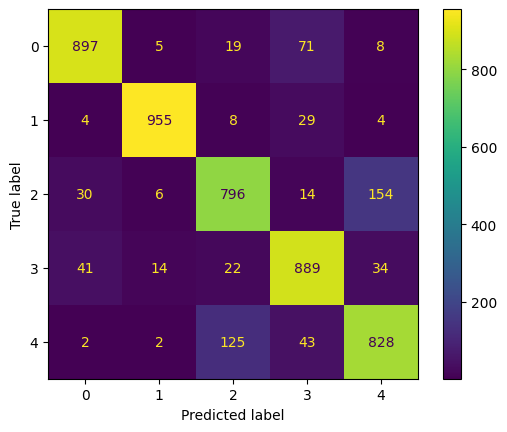

In [187]:
model_evaluate(lr)

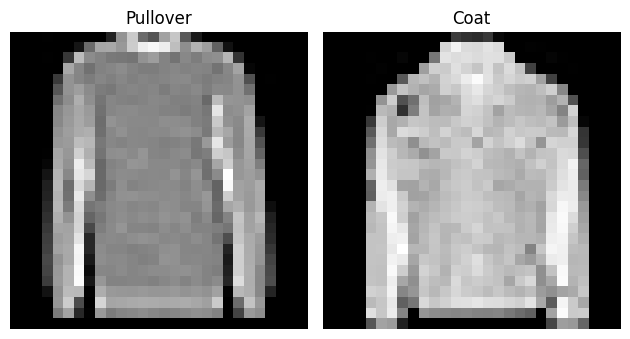

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(df_trn[df_trn['label']==2].iloc[4, 1:].values.reshape(28, 28), cmap='gray')
plt.title('Pullover')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(df_trn[df_trn['label']==4].iloc[4, 1:].values.reshape(28, 28), cmap='gray')
plt.title('Coat')
plt.axis('off')
plt.tight_layout()
plt.show()

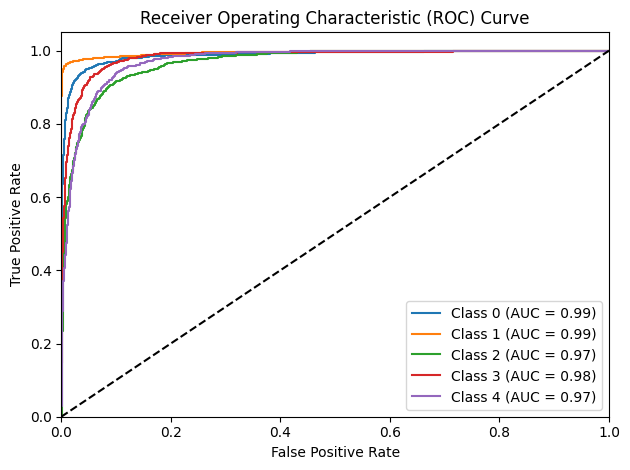

In [189]:
model_roc(lr)

### KNNClassifier

In [190]:
knn= KNeighborsClassifier()

In [191]:
knn.fit(X_trn, y_trn)

KNeighborsClassifier()

Train Accuracy:   0.9291
Test Accuracy:    0.8894
Precision Score:  0.8903442251330539
Recall Score:     0.8893999999999999
Classification Report
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      1000
           1       0.99      0.96      0.98      1000
           2       0.82      0.82      0.82      1000
           3       0.92      0.89      0.90      1000
           4       0.82      0.83      0.83      1000

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



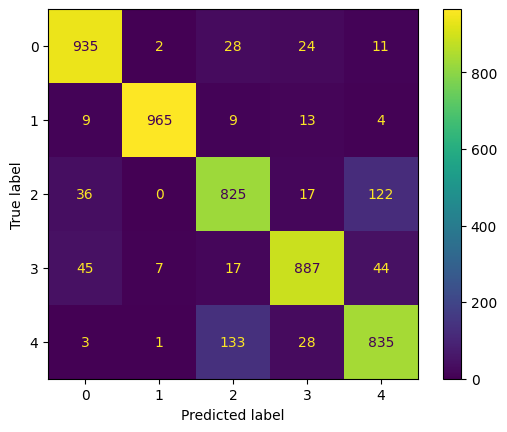

In [192]:
model_evaluate(knn)

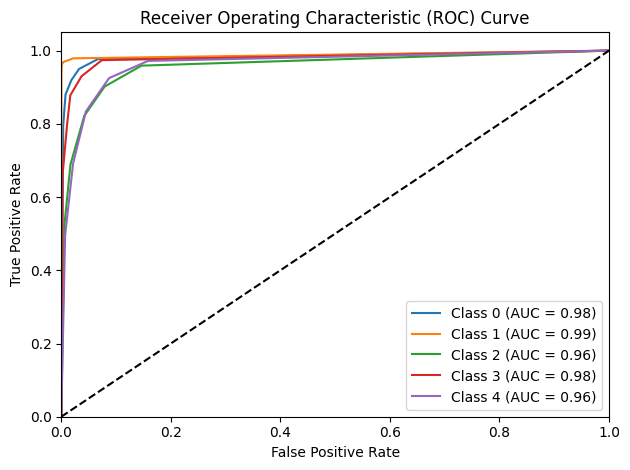

In [193]:
model_roc(knn)

## Other Models

In [198]:
from sklearn.svm      import SVC
from sklearn.tree     import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost          import XGBClassifier
from catboost         import CatBoostClassifier
from lightgbm         import LGBMClassifier

In [199]:
def model_report(model, verbose=True):
	model.fit(X_trn, y_trn)

	y_pred=   model.predict(X_tst)
	trnScore= model.score(X_trn, y_trn)
	tstScore= model.score(X_tst, y_tst)
	accScore= accuracy_score(y_tst, y_pred)
	preScore= precision_score(y_tst, y_pred, average='macro')
	recScore= recall_score(y_tst, y_pred, average='macro')
	cm= confusion_matrix(y_tst, y_pred)

	if verbose:
		print(f'Train Score:     {trnScore}')
		print(f'Test Score:      {tstScore}')
		print(f'Accuracy Score:  {accScore}')
		print(f'Precision Score: {preScore}')
		print(f'Recall Score:    {recScore}')

		ConfusionMatrixDisplay(cm).plot()
		plt.show()
		print()
	
	return {
		'trn':  trnScore,
		'tst':  tstScore,
		'acc':  accScore,
		'pre':  preScore,
		'rec':  recScore,
		# 'cm':   cm,
	}

Evaluating LogisticRegression...
Train Score:     0.8909
Test Score:      0.873
Accuracy Score:  0.873
Precision Score: 0.8738840150789903
Recall Score:    0.873


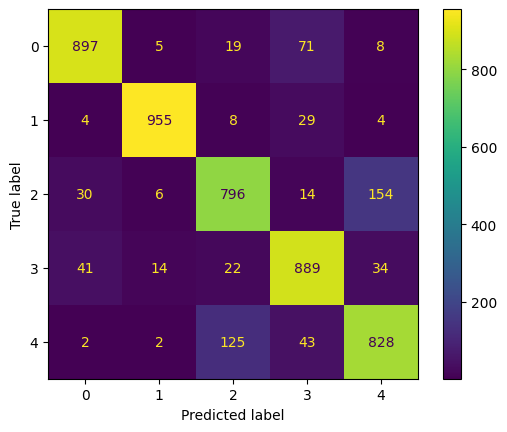


Evaluating KNeighborsClassifier...
Train Score:     0.9291
Test Score:      0.8894
Accuracy Score:  0.8894
Precision Score: 0.8903442251330539
Recall Score:    0.8893999999999999


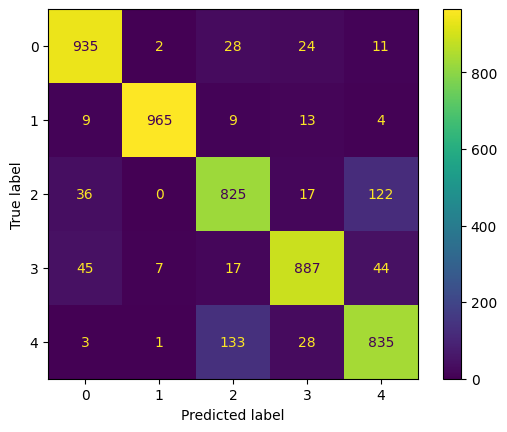


Evaluating Support Vector Classifier...
Train Score:     0.9328666666666666
Test Score:      0.9026
Accuracy Score:  0.9026
Precision Score: 0.9032605416214663
Recall Score:    0.9026


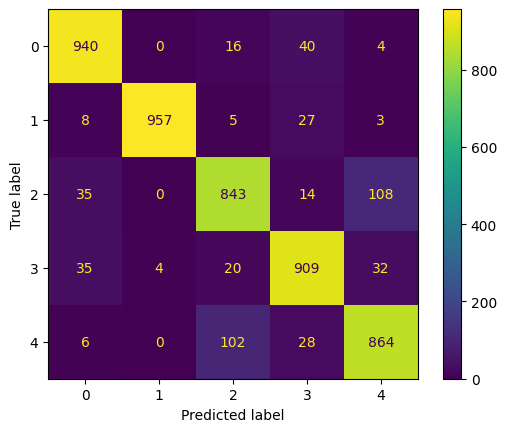


Evaluating DecisionTreeClassifier...
Train Score:     1.0
Test Score:      0.8064
Accuracy Score:  0.8064
Precision Score: 0.8078848030185496
Recall Score:    0.8064


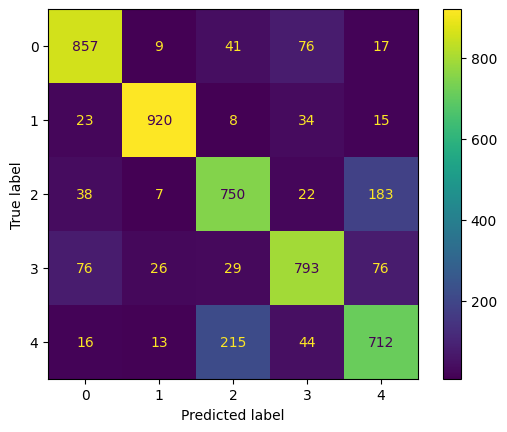


Evaluating RandomForestClassifier...
Train Score:     1.0
Test Score:      0.8924
Accuracy Score:  0.8924
Precision Score: 0.8936410318505903
Recall Score:    0.8924


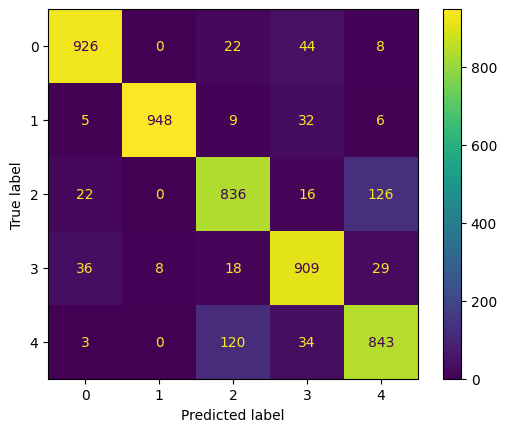


Evaluating BaggingClassifier...
Train Score:     0.9945333333333334
Test Score:      0.8602
Accuracy Score:  0.8602
Precision Score: 0.8611774912903043
Recall Score:    0.8602000000000001


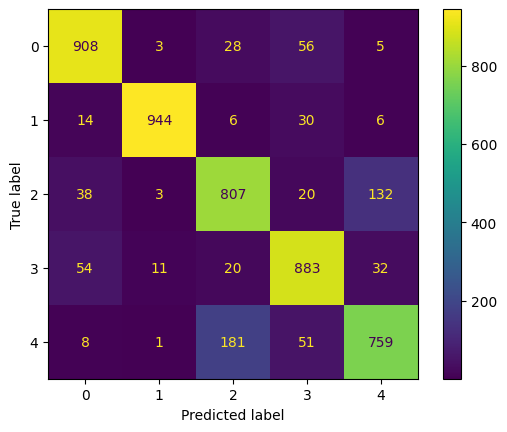


Evaluating ExtraTreesClassifier...
Train Score:     1.0
Test Score:      0.8944
Accuracy Score:  0.8944
Precision Score: 0.8956072978510032
Recall Score:    0.8944000000000001


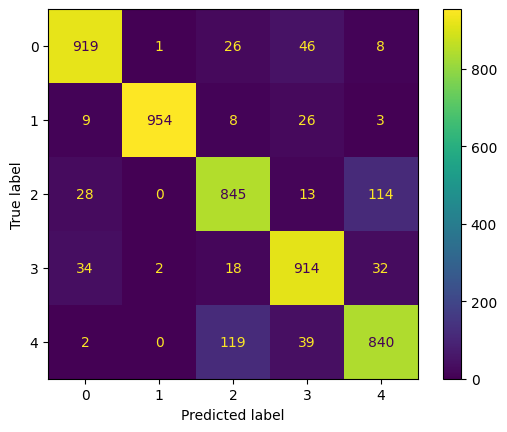


Evaluating AdaBoostClassifier...


d:\Programs\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train Score:     0.7902666666666667
Test Score:      0.771
Accuracy Score:  0.771
Precision Score: 0.7723155949039093
Recall Score:    0.771


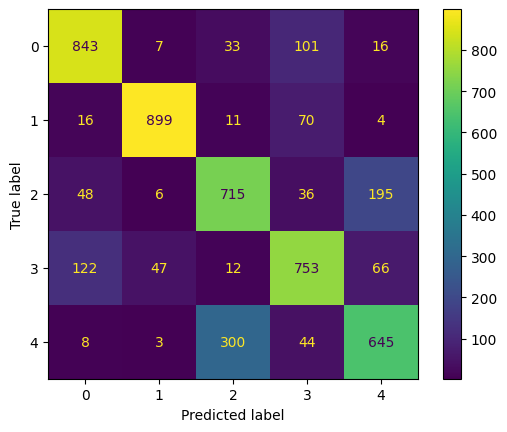


Evaluating XGBClassifier...
Train Score:     1.0
Test Score:      0.9026
Accuracy Score:  0.9026
Precision Score: 0.9031477446095646
Recall Score:    0.9026


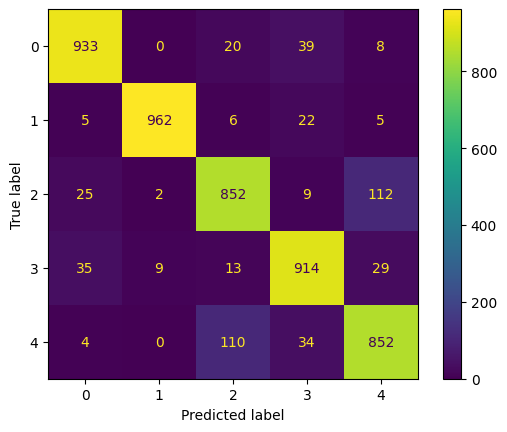


Evaluating CatBoostClassifier...
Train Score:     0.9817333333333333
Test Score:      0.902
Accuracy Score:  0.902
Precision Score: 0.9025087152941552
Recall Score:    0.9019999999999999


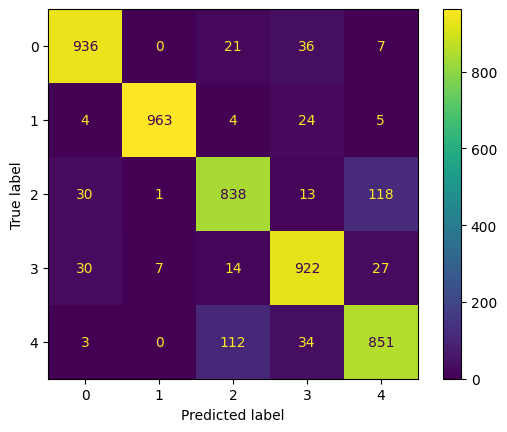


Evaluating LGBMClassifier...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29070
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 114
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Train Score:     0.9901
Test Score:      0.8958
Accuracy Score:  0.8958
Precision Score: 0.8963521510582451
Recall Score:    0.8958


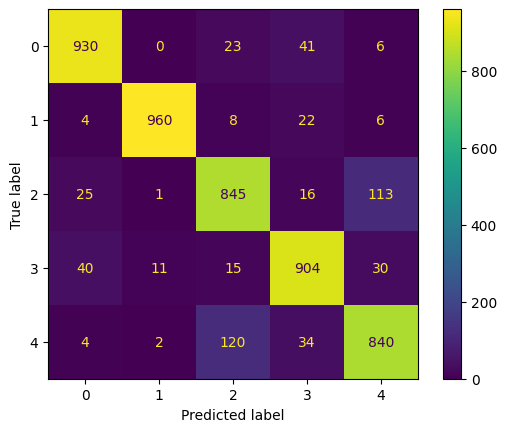


11/11 models evaluated
done


In [200]:
models_dict= {
	'LogisticRegression':        LogisticRegression(max_iter=10_000),
	'KNeighborsClassifier':      KNeighborsClassifier(),
	'Support Vector Classifier': SVC(),
	'DecisionTreeClassifier':    DecisionTreeClassifier(),
	'RandomForestClassifier':    RandomForestClassifier(),
	'BaggingClassifier':         BaggingClassifier(),
	'ExtraTreesClassifier':      ExtraTreesClassifier(),
	'AdaBoostClassifier':        AdaBoostClassifier(),
	'XGBClassifier':             XGBClassifier(),
	'CatBoostClassifier':        CatBoostClassifier(verbose=False),
	'LGBMClassifier':            LGBMClassifier(),
}
models= [{'name':k, 'obj':v} for k,v in models_dict.items()]

i= 0
for model in models:
	print(f"Evaluating {model['name']}...")
	print(f"{i}/{len(models)} models", end='\r')
	model.update(model_report(model['obj']))
	i+= 1
print(f'{i}/{len(models)} models evaluated')
print('done')

In [201]:
pd.DataFrame({
	'Algorithm':       [model['name'] for model in models],
	'Train Score':     [model['trn']  for model in models],
	'Test Score':      [model['tst']  for model in models],
	'Accuracy Score':  [model['acc']  for model in models],
	'Precision Score': [model['pre']  for model in models],
	'Recall Score':    [model['rec']  for model in models],
}).set_index('Algorithm').sort_values(by='Test Score', ascending=False)

,Train Score,Test Score,Accuracy Score,Precision Score,Recall Score
Algorithm,,,,,
Support Vector Classifier,0.932867,0.9026,0.9026,0.903261,0.9026
XGBClassifier,1.000000,0.9026,0.9026,0.903148,0.9026
CatBoostClassifier,0.981733,0.9020,0.9020,0.902509,0.9020
LGBMClassifier,0.990100,0.8958,0.8958,0.896352,0.8958
ExtraTreesClassifier,1.000000,0.8944,0.8944,0.895607,0.8944
RandomForestClassifier,1.000000,0.8924,0.8924,0.893641,0.8924
KNeighborsClassifier,0.929100,0.8894,0.8894,0.890344,0.8894
LogisticRegression,0.890900,0.8730,0.8730,0.873884,0.8730
BaggingClassifier,0.994533,0.8602,0.8602,0.861177,0.8602



## Conclusion

### Data Preparation & Preprocessing


- Our dataset was in the form of unsigned-byte arrays stored in gzip files. We wrote `read_ubyte` function to load it as a pandas Dataframe.

- Both the training and testing datasets had **NO missing values or any duplicated rows**.

- We selected only 5 classes from the 10 available.

- **_Standard Scaling_** and **_Principle Component Analysis_** were performed to ease the training of the models.

### Model Training & Evaluation


- Most models were slightly overfit.

- All models found that the two trickiest classes to differentiate between were class 2 (pullover) and class 4 (coat).


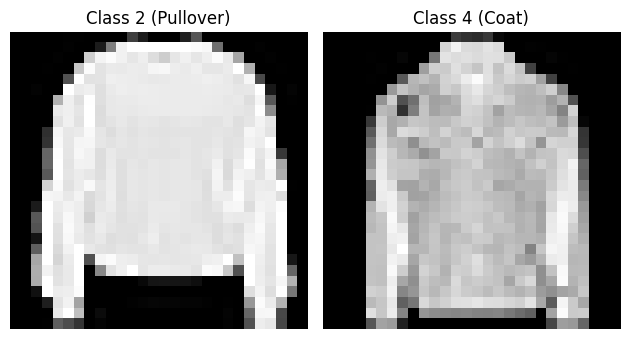

In [202]:
plt.subplot(1, 2, 1)
plt.imshow(df_trn[df_trn['label']==2].iloc[1, 1:].values.reshape(28, 28), cmap='gray')
plt.title('Class 2 (Pullover)')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(df_trn[df_trn['label']==4].iloc[4, 1:].values.reshape(28, 28), cmap='gray')
plt.title('Class 4 (Coat)')
plt.axis('off')
plt.tight_layout()
plt.show()

- Unfortunately scikit-learn doesn't provide a direct way to assess the loss curve during training, only libraries like tensorflow or pytorch do.

- KNN had better accuracy overall than Logistic Regression.

- Support Vector Classifier had the best test accuracy.

- All tree-based models have been greatly overfitted.